In [13]:
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpim
import tensorflow as tf
from tensorflow.keras import layers, models

# Filter directory to only include 'cocci' and 'healthy' classes
directory = 'poultry-diseases-detection/poultry_diseases'


# variables to use
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [ ]:
import os
import shutil

# Dataset directory
dataset_dir = 'poultry-diseases-detection/poultry_diseases'

# List of folders to delete
folders_to_delete = ['ncd', 'salmo']

# Delete folders
for folder in folders_to_delete:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    else:
        print(f"Folder not found: {folder_path}")


In [27]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,)



Found 4160 files belonging to 2 classes.


In [28]:
class_names=dataset.class_names

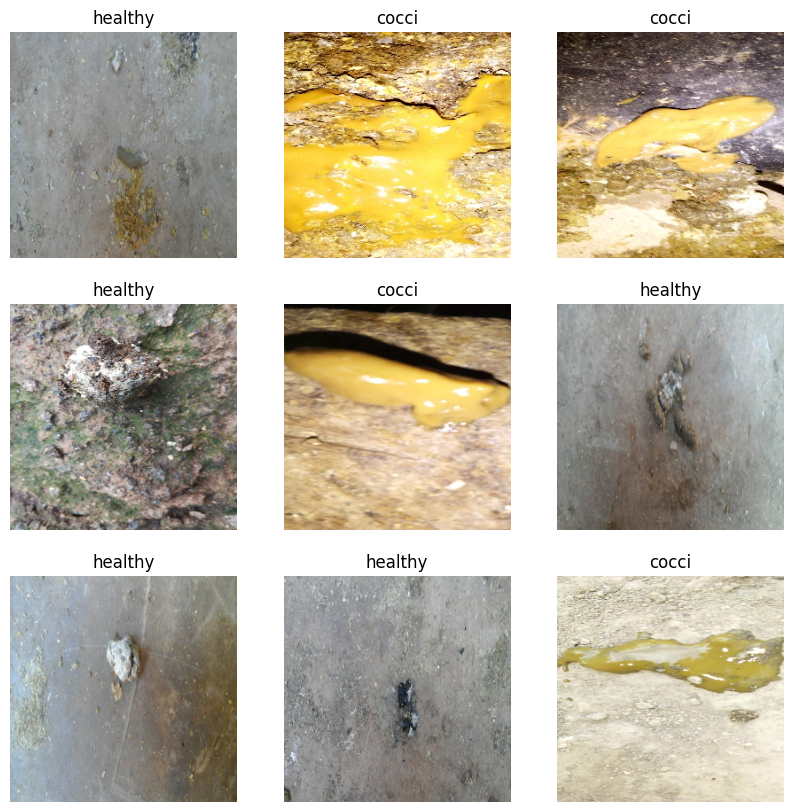

In [32]:
plt.figure(figsize=(10,10))
for img,label in dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i].numpy()])
        plt.axis("off")

In [30]:
# # Splitting the data into train, test, and validation data
# train_size = 0.8
# validation_size = 0.1
# test_size = 0.1

# train_set, val_set, test_set = data_split(dataset, train_size, validation_size, test_size)

def data_split(data,train_size=0.8,validation_size=0.1,test_size=0.1,shuffle=True):
    if shuffle:
        data.shuffle(1000,seed=0)
    train_set=data.take(int(len(data)*train_size))
    val_set=data.skip(len(train_set)).take(int(len(data)*validation_size))
    test_set=data.skip(len(train_set)+len(val_set))
    return train_set, val_set, test_set

In [31]:
train_set, val_set, test_set= data_split(dataset)

In [33]:

# Data preprocessing
train = train_set.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
valid = val_set.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test_set.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)


In [34]:
img_processor=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [35]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor=0.5)
])

In [36]:
# Build our model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

CNN = models.Sequential([
    img_processor,
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])
CNN.build(input_shape)

In [37]:
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [38]:
# Training our model
CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

training_his = CNN.fit(train, epochs=10, validation_data=valid, batch_size=BATCH_SIZE)

Epoch 1/10
104/104 [==============================] - 220s 1s/step - loss: 0.1905 - accuracy: 0.9306 - val_loss: 0.0771 - val_accuracy: 0.9639
Epoch 2/10
104/104 [==============================] - 7s 68ms/step - loss: 0.1039 - accuracy: 0.9657 - val_loss: 0.0641 - val_accuracy: 0.9784
Epoch 3/10
104/104 [==============================] - 7s 66ms/step - loss: 0.0788 - accuracy: 0.9712 - val_loss: 0.0701 - val_accuracy: 0.9736
Epoch 4/10
104/104 [==============================] - 7s 66ms/step - loss: 0.0670 - accuracy: 0.9766 - val_loss: 0.1227 - val_accuracy: 0.9519
Epoch 5/10
104/104 [==============================] - 7s 66ms/step - loss: 0.0655 - accuracy: 0.9778 - val_loss: 0.0736 - val_accuracy: 0.9760
Epoch 6/10
104/104 [==============================] - 7s 65ms/step - loss: 0.0675 - accuracy: 0.9745 - val_loss: 0.0796 - val_accuracy: 0.9543
Epoch 7/10
104/104 [==============================] - 7s 65ms/step - loss: 0.0671 - accuracy: 0.9781 - val_loss: 0.0780 - val_accuracy: 0.9688

In [39]:
scores = CNN.evaluate(train)

104/104 [==============================] - 2s 23ms/step - loss: 0.0537 - accuracy: 0.9784


In [40]:
scores

[0.053673647344112396, 0.9783653616905212]

In [41]:
# Analysing the output
training_his.params

{'verbose': 1, 'epochs': 10, 'steps': 104}

In [42]:
training_his.history


{'loss': [0.19053639471530914,
  0.103904590010643,
  0.07877452671527863,
  0.06697986274957657,
  0.0655270665884018,
  0.06754213571548462,
  0.06713534891605377,
  0.05751548707485199,
  0.08059524744749069,
  0.062198445200920105],
 'accuracy': [0.930588960647583,
  0.965745210647583,
  0.9711538553237915,
  0.9765625,
  0.9777644276618958,
  0.9744591116905212,
  0.9780648946762085,
  0.9786658883094788,
  0.9714543223381042,
  0.9783653616905212],
 'val_loss': [0.07708938419818878,
  0.06414800882339478,
  0.07010260224342346,
  0.12270018458366394,
  0.0736403837800026,
  0.07957044988870621,
  0.07800750434398651,
  0.1354808807373047,
  0.07359039783477783,
  0.08021029829978943],
 'val_accuracy': [0.963942289352417,
  0.9783653616905212,
  0.973557710647583,
  0.9519230723381042,
  0.9759615659713745,
  0.9543269276618958,
  0.96875,
  0.9375,
  0.9711538553237915,
  0.9663461446762085]}

In [45]:
for key, values in training_his.history.items():
    training_loss = training_his.history['loss']
    training_accuracy = training_his.history['accuracy']
    validation_loss = training_his.history['val_loss']
    validation_accuracy = training_his.history['val_accuracy']

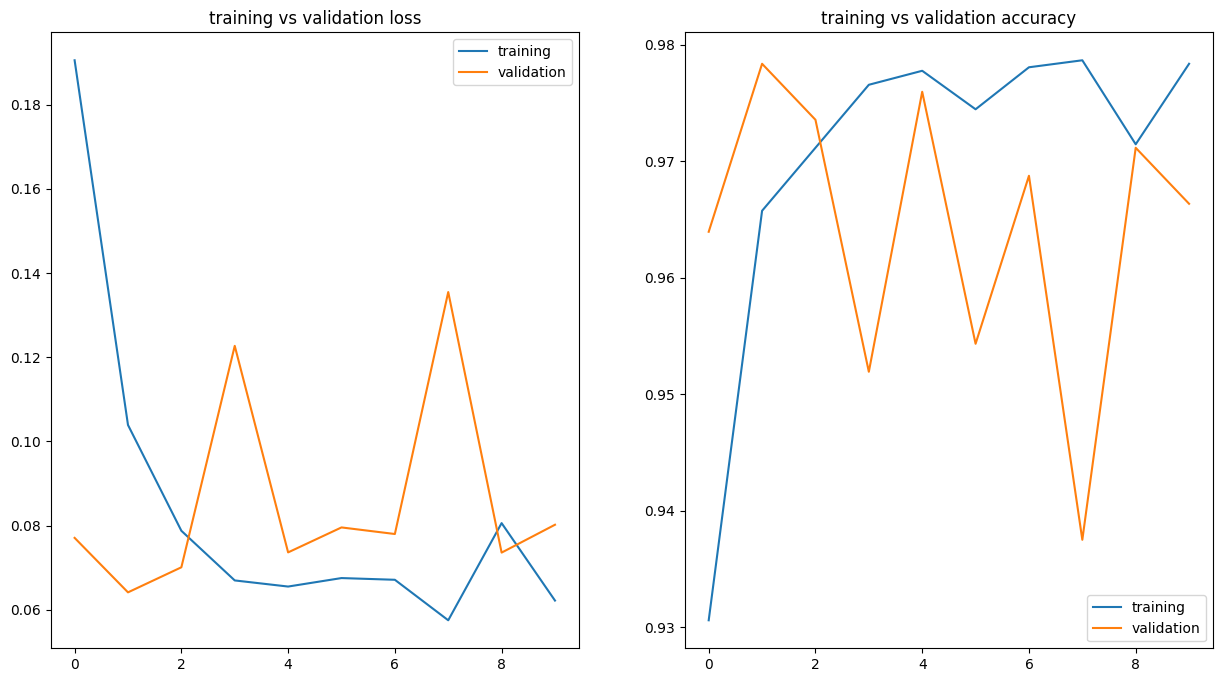

In [44]:
plt.figure(figsize=(15, 8))
ax = plt.subplot(1, 2, 1)
plt.plot(range(len(training_loss)), training_loss, label='training')
plt.plot(range(len(validation_loss)), validation_loss, label='validation')
plt.title('training vs validation loss')
plt.legend(loc='upper right')
ax = plt.subplot(1, 2, 2)
plt.plot(range(len(training_accuracy)), training_accuracy, label='training')
plt.plot(range(len(validation_accuracy)), validation_accuracy, label='validation')
plt.title('training vs validation accuracy')
plt.legend(loc='lower right')

1/1 [==============================] - 0s 165ms/step


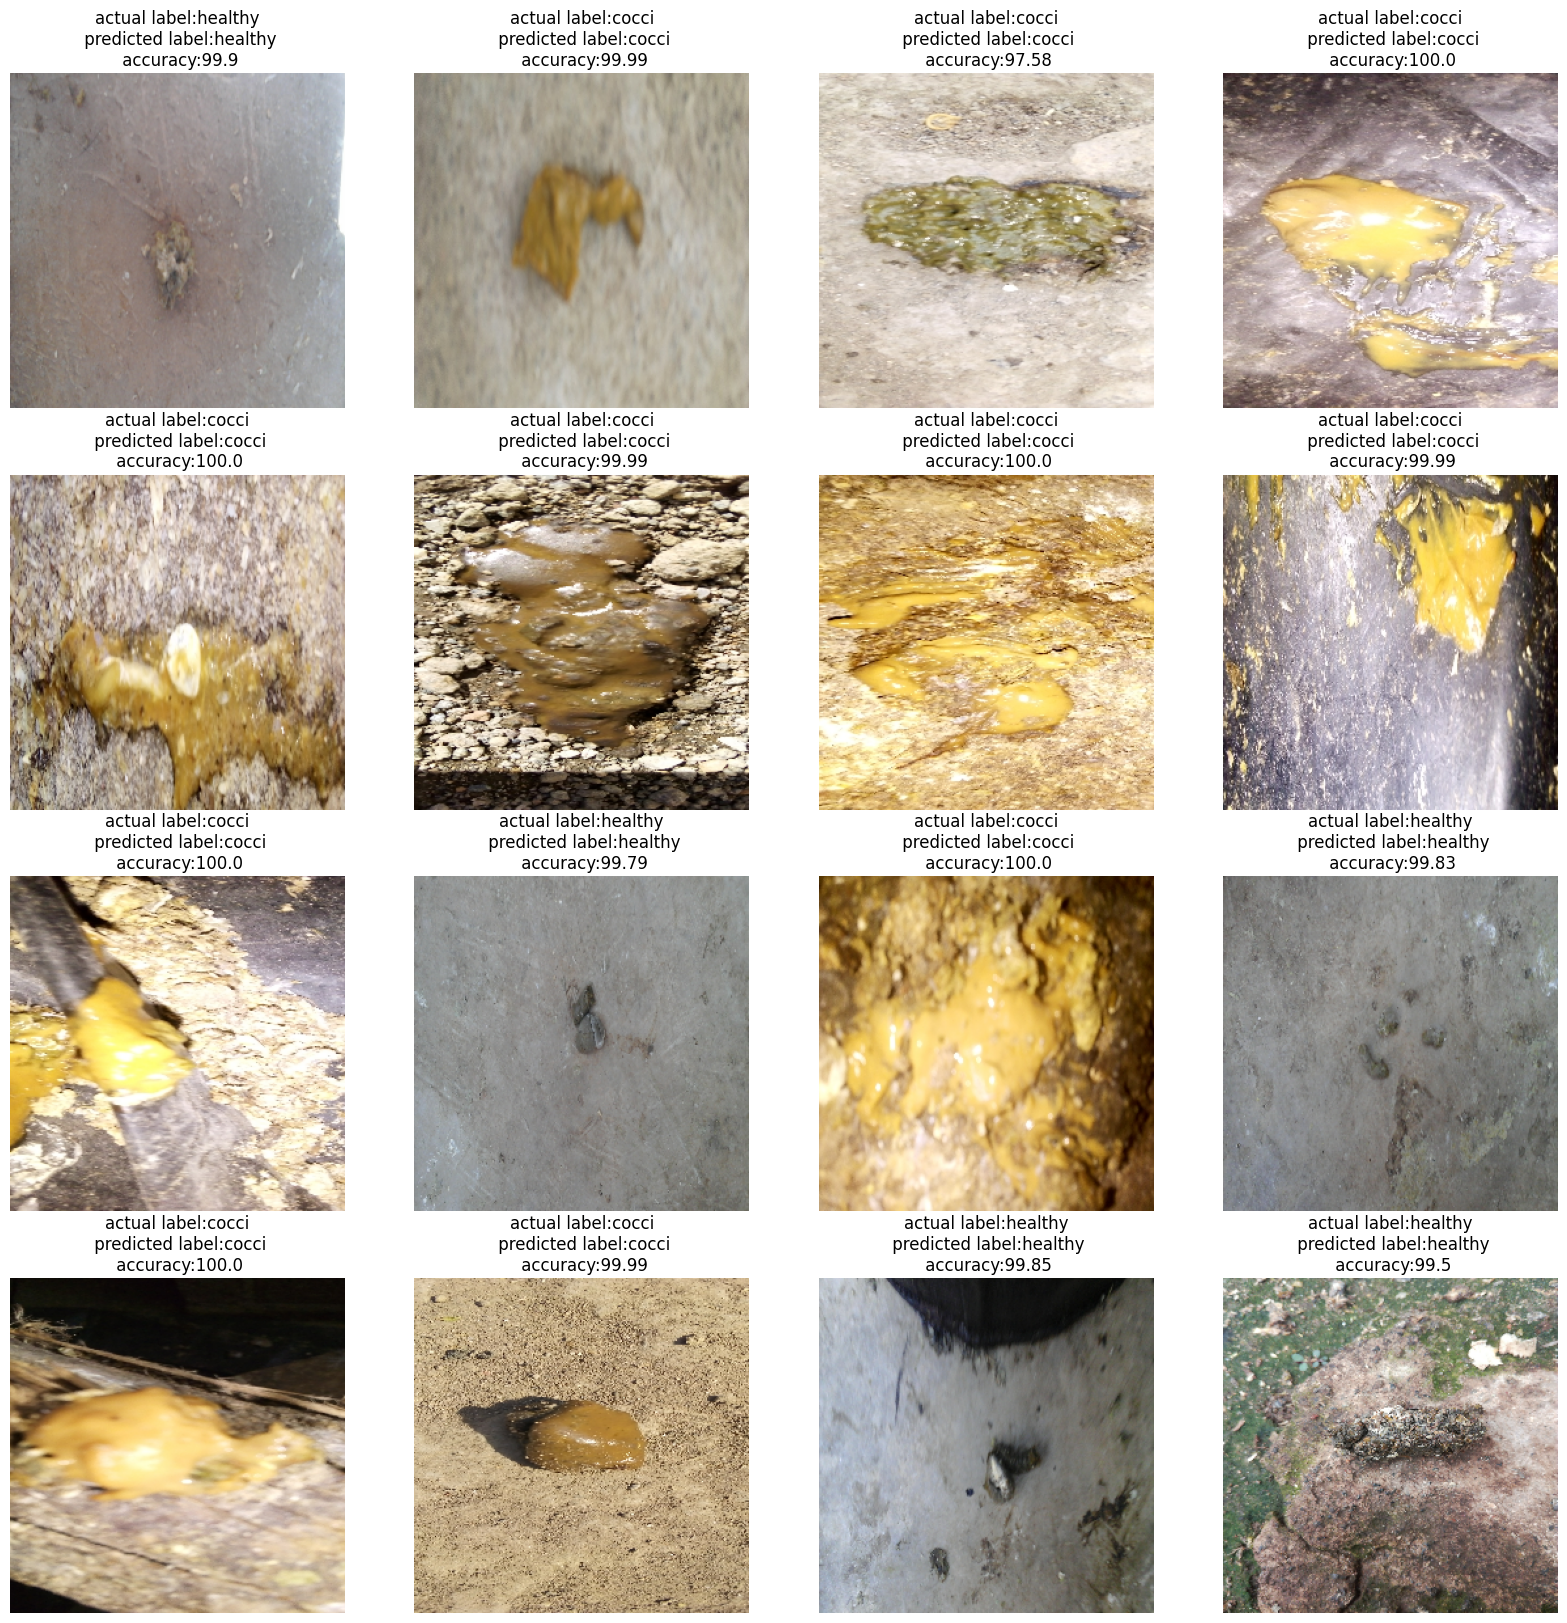

In [46]:
plt.figure(figsize=(20, 20))
for img, label in test.take(1):
    batch_prediction = CNN.predict(img)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        actual_label = class_names[label[i].numpy()]
        predicted_label = class_names[np.argmax(batch_prediction[i])]
        accuracy = round(np.max(batch_prediction[i]) * 100, 2)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(f'actual label:{actual_label}\n predicted label:{predicted_label}\n accuracy:{accuracy}')
        plt.axis("off")